# Image classification using AWS sagemaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**intro:** In this project I will be using a pretrained model which is Resnet34 to classify various dog spieces provided in the dogbreed dataset in the ND classroom.


In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 29.7 MB/s            
     |████████████████████████████████| 83 kB 218 kB/s              
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 881.9 

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

## Dataset
the dataset in use consists of different dog breeds, there are around 133 different species of dogs, the dataset is divided into train,test and evalutaion datasets each consists of different set of images.

In [4]:
#setting up sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [5]:

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-22 14:57:32--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.128
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.2MB/s    in 26s     

2021-12-22 14:58:07 (42.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [6]:
#uploaing to S3
bucket = sagemaker_session.default_bucket()
import os
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-576103581852/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/001

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
#estimator and tuner to tune HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'hpo_tuning_dog_breed',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# setting up S3 for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [10]:
# TODO: Fit your HP Tuner
tuner.fit({'train' : s3_data},wait=True)  # TODO: Remember to include your data channels

...................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-22 15:55:28 Starting - Preparing the instances for training
2021-12-22 15:55:28 Downloading - Downloading input data
2021-12-22 15:55:28 Training - Training image download completed. Training in progress.
2021-12-22 15:55:28 Uploading - Uploading generated training model
2021-12-22 15:55:28 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.001333526980868272',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_breed-2021-12-22-15-41-20-986"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-576103581852/hpo_tuning_dog_breed-2021-12-22-15-41-20-986/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [15]:
# TODO: Create and fit an estimator

hyperparameters = {"batch_size": "32", "lr": "0.001333526980868272"} #best HPs for training
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : s3_data},wait=True)

2021-12-22 16:12:39 Starting - Starting the training job...
2021-12-22 16:13:03 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-22 16:14:03 Starting - Preparing the instances for training.........
2021-12-22 16:15:34 Downloading - Downloading input data.........
2021-12-22 16:17:04 Training - Downloading the training image...
2021-12-22 16:17:35 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-22 16:17:27,599 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-12-22 16:17:27,621 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-22 16:17:27,625 sagemaker_pytorch_container.training INFO     Invoking user training script.
2

In [16]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2021-12-22-16-12-39-234
Region: us-east-1
[2021-12-22 16:22:00.019 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:22 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-22 16:22:00.031 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:22 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/debug-output
[2021-12-22 16:22:02.843 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:22 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-22 16:22:03.865 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:22 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_

In [17]:
#setting tensor
tensor_name = "CrossEntropyLoss_output_0"

In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 [array(4.9094076, dtype=float32),
  array(4.8292775, dtype=float32),
  array(4.891288, dtype=float32),
  array(4.5422945, dtype=float32),
  array(4.449066, dtype=float32),
  array(4.0192714, dtype=float32),
  array(3.8912933, dtype=float32),
  array(3.2352958, dtype=float32),
  array(2.7793183, dtype=float32),
  array(3.3657184, dtype=float32),
  array(3.1743991, dtype=float32),
  array(2.1578062, dtype=float32),
  array(2.0318837, dtype=float32),
  array(2.2321806, dtype=float32),
  array(1.7911124, dtype=float32),
  array(2.1559944, dtype=float32),
  array(2.208668, dtype=float32),
  array(2.234131, dtype=float32),
  array(2.186626, dtype=float32),
  array(1.8219172, dtype=float32),
  array(1.804915, dtype=float32)])

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


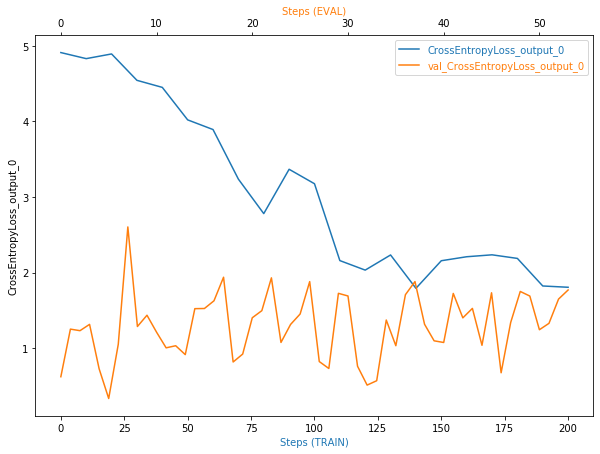

In [19]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

**answer:** I think that the values for the loss are extremely volatile, they should be smoother, this roughness in the momentum is probably due to the choice of layer numbers in the FC model and the resnet, it could be solved by finding a better combination for those.

In [20]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/rule-output


In [21]:
! aws s3 ls {rule_output_path} --recursive

2021-12-22 16:19:38     335926 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-22 16:19:37     178317 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-22 16:19:33        191 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-22 16:19:33       6659 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-22 16:19:33        126 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-22 16:19:33        129 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-22 16:19:33       3428 pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-re

In [22]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-57610358185

In [23]:
import os

# getting the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
import IPython
# outputing the profiler report in here
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

**I had problems creating the endpoint as the process was not going smoothly and got module errors, will be using an a deployment script**

In [25]:
# TODO: Deploy your model to an endpoint
#setting model location
model_location= "s3://sagemaker-us-east-1-576103581852/pytorch-training-2021-12-22-16-12-39-234/output/model.tar.gz"

In [26]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


In [27]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference_alt.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [28]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

--------!

In [31]:
with open("./puppyfortest.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

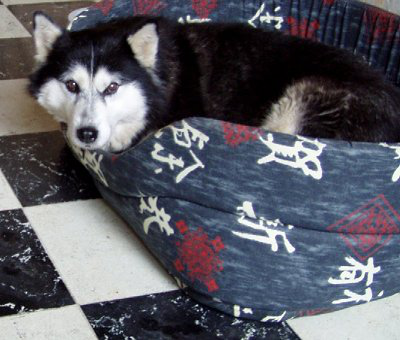

In [32]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [36]:
# TODO: Run an prediction on the endpoint
result=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

In [40]:
import numpy as np
np.argmax(result, 1)

array([4])

In [ ]:
#prediction seems to be almost correct, alaskan dogs look like Akita dogs

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()